In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

import pickle

# Vanilla LSTM

In [ ]:
model = tf.keras.models.Sequential()

In [ ]:
model.add(layers.LSTM(20, input_shape=(10, 1),return_sequences=True))

In [ ]:
model.add(layers.TimeDistributed(layers.Dense(1, activation="sigmoid")))

In [ ]:
model.compile(
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [ ]:
n_timestamps = 10

In [ ]:
X = np.random.rand(n_timestamps)

In [ ]:
limit = n_timestamps / 4.0

In [ ]:
y = (np.cumsum(X) > limit).astype(np.int32) 

In [ ]:
y

In [ ]:
X = np.expand_dims(np.expand_dims(X, -1), 0)
y = np.expand_dims(np.expand_dims(y, -1), 0)

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
model.fit(X, y, epochs=10)

In [ ]:
model.summary()

# BiLSTM

In [ ]:
bilstm_model = tf.keras.models.Sequential()

In [ ]:
bilstm_model.add(layers.Bidirectional(layers.LSTM(20, return_sequences=True), input_shape=(n_timestamps, 1)))
bilstm_model.add(layers.TimeDistributed(layers.Dense(1, activation="sigmoid")))

In [ ]:
bilstm_model.compile(
    optimizer=tf.train.AdadeltaOptimizer(learning_rate=0.01),
    loss="binary_crossentropy",
    metrics=["acc"]
)

In [ ]:
bilstm_model.fit(X, y, epochs=10)

In [ ]:
model.summary()

In [ ]:
bilstm_model.summary()

# BLSTM for frames

In [2]:
frame_dim = 1024
player_dim = 3472

In [3]:
num_hidden_states = 256
embedding_dim = 256

In [4]:
n_timestamps = 24

# Classification Network

In [266]:
batch_size = 64

In [252]:
k = 11
num_players = 10

In [253]:
ft = layers.Input(shape=(n_timestamps, frame_dim))
pt = layers.Input(shape=(num_players, n_timestamps, player_dim))

ft_embed = layers.Dense(embedding_dim, activation="relu")(ft)
pt_embed = layers.Dense(embedding_dim, activation="relu")(pt)

h_f = layers.Bidirectional(layers.LSTM(num_hidden_states, return_sequences=True), input_shape=(n_timestamps, embedding_dim))(ft_embed)
h_f_repeated = layers.Lambda(lambda x: K.repeat_elements(K.expand_dims(x, 1), rep=num_players, axis=1))(h_f)

#h_p = layers.TimeDistributed(layers.Masking(mask_value=0., input_shape=(n_timestamps, embedding_dim)))(pt_embed)
h_p = layers.TimeDistributed(layers.Bidirectional(layers.LSTM(num_hidden_states, return_sequences=True), input_shape=(n_timestamps, embedding_dim)))(pt_embed)

concatenate = layers.Concatenate()([h_f_repeated, h_p])
logits = layers.Dense(1, activation="relu")(concatenate)
permute = layers.Permute((2, 3, 1))(logits)

attention_probs = layers.Softmax(name="attention")(permute)
attention_probs = layers.Permute((3, 1, 2))(attention_probs)

merge = layers.Multiply()([h_p, attention_probs])
a_t = layers.Lambda(lambda x: K.sum(x, axis=1))(merge)

c_t = layers.Concatenate()([h_f, a_t])
h_e = layers.LSTM(num_hidden_states, return_sequences=True, input_shape=(n_timestamps, 2 * embedding_dim))(c_t)
outputs = layers.Dense(k, activation="linear")(h_e)

In [254]:
def squared_hinge_loss(y_true, y_pred):
    # y_true 100x11, y_pred 100x24x11
    # print(y_pred.get_shape())
    L = 0.5 * K.sum(K.square(K.maximum(0., 1. - y_true * y_pred)), axis=[-1, -2])
    return K.mean(L)

In [255]:
class_model = tf.keras.Model(inputs=[ft, pt], outputs=outputs)

In [256]:
def our_acc(y_true, y_pred):
    # y_true batch_size x 24 x 11
    # y_pred batch_size x 24 x 11
    #K.mean(K.argmax(y_pred, axis=-1) == K.argmax(y_true, axis=-1)
    label_pred = K.sum(y_pred, axis=-2)
    label_true = K.sum(y_true, axis=-2)
    #print(K.equal(K.argmax(label_pred, axis=-1), K.argmax(label_true, axis=-1)))
    #print(K.cast(K.equal(K.argmax(label_pred, axis=-1), K.argmax(label_true, axis=-1)), dtype="float16"))
    
    return K.mean(K.cast(K.equal(K.argmax(label_pred, axis=-1), K.argmax(label_true, axis=-1)), dtype="float32"))
    

In [257]:
class_model.compile(
    optimizer=tf.train.RMSPropOptimizer(learning_rate=0.001),
    loss=squared_hinge_loss,
    metrics=[our_acc]
)

In [258]:
class_model.summary(line_length=150)

______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
input_11 (InputLayer)                            (None, 24, 1024)                 0                                                                   
______________________________________________________________________________________________________________________________________________________
dense_20 (Dense)                                 (None, 24, 256)                  262400            input_11[0][0]                                    
______________________________________________________________________________________________________________________________________________________
input_12 (InputLayer)                            (None, 10, 24, 3472)             0           

In [259]:
import numpy as np
import tensorflow.keras as keras

from collections import Counter
import pickle

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, event_ids, classes, batch_size=32, frame_dim=1024, player_dim=3472, n_players=10, n_frames=24, shuffle=True):
        'Initialization'
        self.batch_size = batch_size
        self.classes = classes
        self.event_ids = event_ids
        self.player_dim = player_dim
        self.frame_dim = frame_dim
        self.n_frames = n_frames
        self.n_players = n_players
        self.n_classes = len(classes)
        self.shuffle = shuffle
        self.on_epoch_end()
        
        self.label2idx = {label: idx for idx,label in enumerate(classes)}

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.event_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        event_ids_temp = [self.event_ids[k] for k in indexes]

        # Generate data
        f_t, p_t, labels = self.__data_generation(event_ids_temp)

        return [f_t, p_t], labels

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.event_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, event_ids_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        ft_batch = np.empty((self.batch_size, self.n_frames, self.frame_dim))
        pt_batch = np.empty((self.batch_size, self.n_players, self.n_frames, self.player_dim)) 
        labels_batch = np.empty((self.batch_size, self.n_frames, self.n_classes), dtype=int)
        
        labels  = [None]* self.batch_size
        # Generate data
        for i, event_id in enumerate(event_ids_temp):
            input_file = open('../data/event_features_correct/' + event_id + '.pickle', 'rb')
            
          # Store sample
            event = pickle.load(input_file)
            ft, pt, label = self.tensorize_event(event, input_file)
            
            ft_batch[i,] = ft
            pt_batch[i,] = pt
            labels[i] = label
        
        labels = keras.utils.to_categorical(labels, num_classes=self.n_classes)
        labels = 2 * labels -  1
        labels_batch = np.repeat(labels, self.n_frames, axis=0).reshape(self.batch_size, self.n_frames, self.n_classes)
        return ft_batch, pt_batch, labels_batch
        
    def tensorize_event(self, event, input_file):
        feature, label = event
        frame_features, player_dicts = zip(*feature)
        frame_features = frame_features[:self.n_frames]
        player_dicts = player_dicts[:self.n_frames]

        p_t = np.zeros((self.n_players,self.n_frames,self.player_dim))
        
        # Get all player ids
        player_frame_counts = Counter()

        for player_dict in player_dicts:
            player_frame_counts.update(player_dict.keys())

        player_ids, _ = zip(*player_frame_counts.most_common(self.n_players))

        for player_idx,player_id in enumerate(player_ids):
            for frame_idx, player_dict in enumerate(player_dicts):
                if frame_idx >= self.n_frames:
                    print(input_file)
                    break
                if player_id in player_dict:
                    p_t[player_idx, frame_idx, : ] = player_dict[player_id]

        f_t = np.array(frame_features)

        label = self.label2idx[label]

        return f_t, p_t, label
 

In [260]:
classes = [
    'layup failure',
    'layup success',
    'steal success',
    'other 2-pointer failure',
    '3-pointer success',
    'other 2-pointer success',
    'free-throw success',
    '3-pointer failure',
    'free-throw failure',
    'slam dunk success',
    'slam dunk failure'
]

In [261]:
import pandas as pd

event_data_path = "../data/bball_dataset_april_4.csv"
event_data = pd.read_csv(event_data_path, header=None)

columns = [
    "#YoutubeId",
    "VideoWidth",
    "VideoHeight",
    "ClipStartTime",
    "ClipEndTime",
    "EventStartTime",
    "EventEndTime",
    "EventStartBallX",
    "EventStartBallY",
    "EventLabel",
    "TrainValOrTest",
]

event_data.columns = columns

In [262]:
import os

event_files = os.listdir("../data/event_features_correct//")
video_ids = set(event_file[6:17] for event_file in event_files)

event_id2label = {}

for video_id in video_ids:
    sample = event_data[event_data["#YoutubeId"] == video_id]
    sample = sample.sort_values(by="EventEndTime")
    
    for idx, label in enumerate(sample["EventLabel"].tolist()):
        event_id2label["event_" + video_id + "_{:03d}".format(idx)] = label


In [263]:
import os

event_ids = [f.split(".")[0] for f in os.listdir("../data/event_features_correct/")]
labels = [event_id2label[event_id] for event_id in event_ids]

from sklearn.model_selection import train_test_split

train_event_ids, validation_event_ids, train_labels, test_labels = train_test_split(event_ids, 
                                                                                    labels, 
                                                                                    shuffle=True, 
                                                                                    stratify=labels,
                                                                                    test_size=0.2) 
#train_event_ids = event_ids[:-200]
#validation_event_ids = event_ids[-200:]


In [264]:
len(train_event_ids), len(validation_event_ids)

(3470, 868)

In [267]:
train_gen = DataGenerator(event_ids=train_event_ids, n_frames=24, n_players=10, classes=classes, batch_size=batch_size)
valid_gen = DataGenerator(event_ids=validation_event_ids, n_frames=24, n_players=10, classes=classes, batch_size=batch_size)

In [ ]:
history = class_model.fit_generator(generator=train_gen, validation_data=valid_gen, epochs=20)

Epoch 1/20
54/54 [==============================] - 889s 16s/step - loss: 52.8239 - our_acc: 0.1548 - val_loss: 50.8169 - val_our_acc: 0.1767
Epoch 2/20
51/54 [===========================>..] - ETA: 34s - loss: 45.7049 - our_acc: 0.1875

In [63]:
# history_dict_1 = history.history

In [250]:
class_model.save('3470_868.h5')

In [244]:
history_dict = history.history

In [245]:
val_loss = history_dict["val_loss"]
val_our_acc = history_dict["val_our_acc"]
loss = history_dict["loss"]
our_acc = history_dict["our_acc"]

In [246]:
epochs = np.arange(1, len(val_loss) + 1)

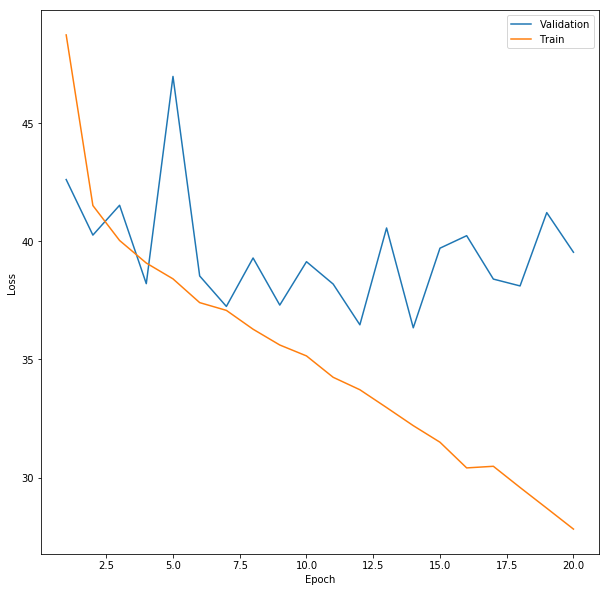

In [247]:
plt.figure(figsize=(10, 10))
plt.plot(epochs, val_loss)
plt.plot(epochs, loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Validation", "Train"])

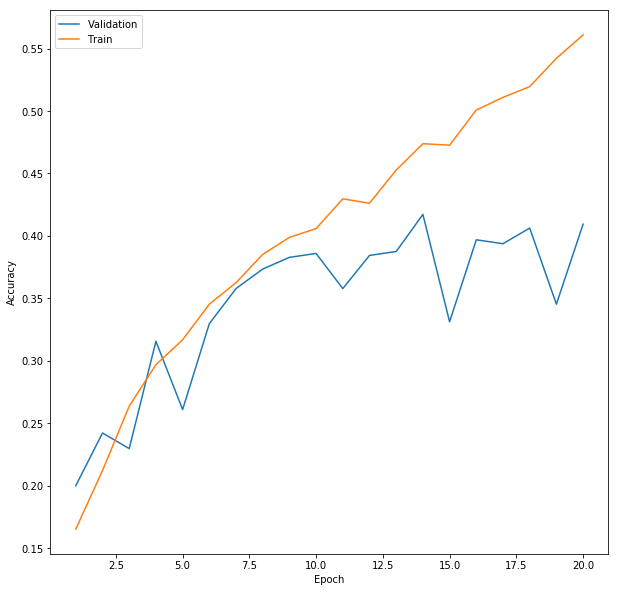

In [248]:
plt.figure(figsize=(10, 10))
plt.plot(epochs, val_our_acc)
plt.plot(epochs, our_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Validation", "Train"])

In [249]:
with open("almost-sota-3470-868-vision.pkl", "wb") as f:
    pickle.dump((val_loss, val_our_acc, loss, our_acc), f)

# Attention Analysis

In [131]:
from feature_extraction import *
from data_extraction import *

In [132]:
event_data = read_event_data("../data/bball_dataset_april_4.csv")
bbox_data = read_bboxes_data("../data/train_test_val_merged_detections_v2_ts_fixed.csv")

video_id = "4mrTUWACzoQ"

events_paths = [os.path.join("../data/events", event) for event in os.listdir("../data/events") if video_id in event]
video_data = event_data[event_data["#YoutubeId"] == video_id]
video_data = video_data.sort_values(by="EventEndTime")

events_paths = sorted(events_paths)

event_map = create_events_map(event_data=video_data, events_paths_list=events_paths)
reverse_event_map = {value: key for key, value in event_map.items()}

video_bbox = bbox_data[bbox_data["Youtube ID"] == video_id]
event_bboxtimes_map = create_eventbboxtimes_map(video_bbox, event_map)

layer = "avgpool0"
width = 490
height = 360
f_ts = []
p_ts = []
frames = []
players = []
for frame, player_dict in extract_players_from_frames(events_paths[0], event_bboxtimes_map, reverse_event_map[events_paths[0]], video_bbox, width, height):
    t_obj = T(layer)
    f_t = extract_frame_features(frame=frame, kernel_size=(5, 5), new_shape=(224, 224), sigma=0.1, t_obj=t_obj)
    p_t = []
    for player in player_dict:
        with tf.Session() as sess:
            p_t.append(extract_localized_features_for_person(player_dict[player]))

    f_ts.append(f_t)
    p_ts.append(p_t)
    frames.append(frame)
    players.append(player_dict)


In [150]:
f_t = np.expand_dims(np.array(f_ts), 0)

In [136]:
len(players)

24

In [144]:
p_t = np.zeros([num_players, n_timestamps, player_dim])
for i, player_vectors in enumerate(p_ts):
    p_t[:min(len(player_vectors), num_players), i, :] = player_vectors[:num_players]
    

In [147]:
p_t = np.expand_dims(p_t, 0)

In [151]:
f_t.shape

(1, 24, 1024)

In [152]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    attention_weights = sess.run(class_model.get_layer("attention").output, {ft: f_t, pt: p_t})

In [155]:
attention_weights = attention_weights.squeeze()

In [156]:
attention_weights.shape

(24, 10)

In [159]:
key_players = attention_weights.argmax(axis=1)

In [161]:
import matplotlib.pyplot as plt
import cv2 as cv

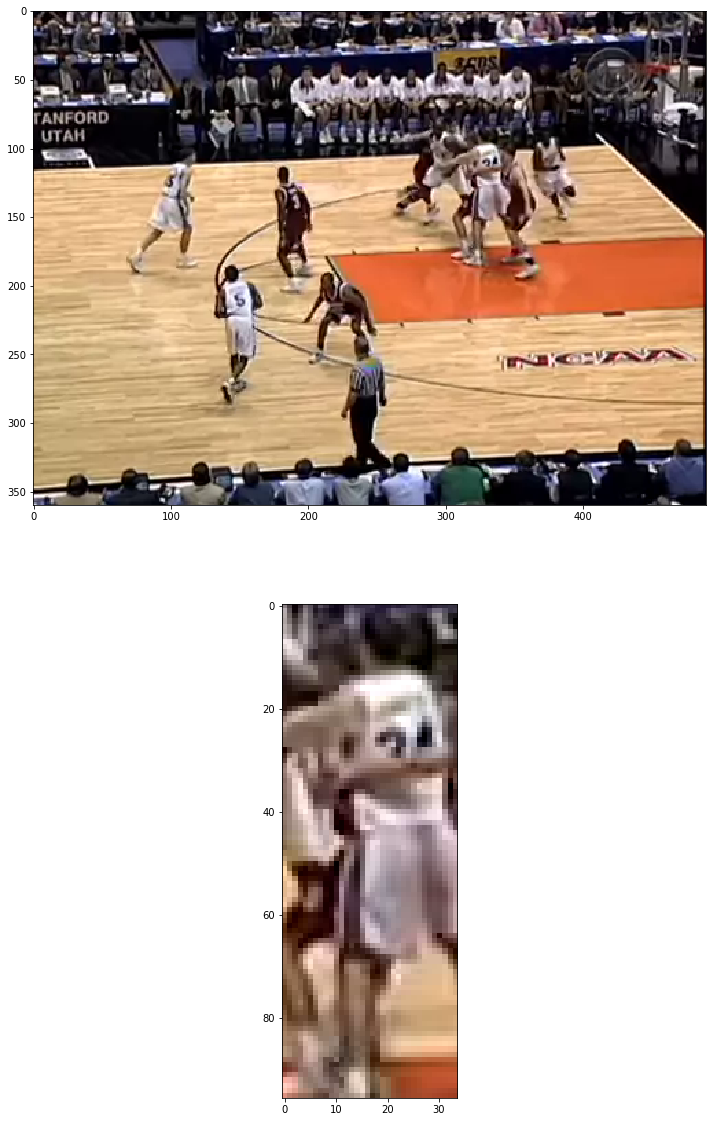

In [164]:
for i, frame in enumerate(frames):
    player_dict = players[i]
    player_regions = list(player_dict.values())
    fig, axes = plt.subplots(2, figsize=(20, 20))
    axes[0].imshow(cv.cvtColor(frame, cv.COLOR_BGR2RGB))
    axes[1].imshow(cv.cvtColor(player_regions[key_players[i]], cv.COLOR_BGR2RGB))
    
    break